In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Let's import all the required python packages
import io
import os
import re
import nltk
import boto3
import pickle
import random
import string
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.svm import SVC
from datetime import datetime
from botocore import exceptions
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import model_selection
from contextlib import contextmanager
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from skmultilearn.ensemble import LabelSpacePartitioningClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from skmultilearn.cluster.networkx import NetworkXLabelGraphClusterer
from simpletransformers.language_representation import RepresentationModel

# Ipython magic function which helps to display the plots inside the notebook itself
%matplotlib inline

import warnings  # seaborn generates a bunch of warnings that we'll ignore

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [3]:
# S3 Config Params
BUCKET_NAME = "hive-s3-lz"
BASE_PREFIX = "medicare-voicemail"
DATASET_PREFIX = f"{BASE_PREFIX}/dataset"
TOPIC_CLASSIFIER = datetime.now().strftime("Topic_Classifier_Model_%H-%M-%d-%m-%Y")
MODEL_PREFIX = f"{BASE_PREFIX}/models/{TOPIC_CLASSIFIER}"


# Initializing S3 client and resource objects
S3_CLIENT = boto3.client("s3")
S3_RESOURCE = boto3.resource("s3")

NUM_EPOCHS = 10
LABELS = [
    "Access to Care",
    "Authorization",
    "Benefits",
    "Claim",
    "EE Benefits",
    "Grievance and/or Appeal",
    "ID Card",
    "Membership/Enrollment",
    "Monthly Premium",
    "Need Case Management",
    "No Reason Given",
    "Nurse Line",
    "OTC",
    "Provider",
    "RX/Pharmacy",
    "Transportation",
]
ANCHOR_WORDS = {
    "Claim": [
        "bill",
        "claim",
        "calling claim",
        "calling bill",
        "received bill",
        "got bill",
        "billed",
    ],
    "Benefits": ["benefit", "dental", "vision", "coverage"],
    "Grievance and/or Appeal": [
        "grievance",
        "appeal",
        "complaint",
        "file grievance",
        "filed",
    ],
    "Membership/Enrollment": ["plan", "insurance", "enrollment", "policy", "enrolled"],
    "OTC": ["order", "otc", "otc card", "place otc", "place order"],
    "ID Card": ["card", "id card", "need new", "card need", "new id"],
    "Need Case Management": [
        "case manager",
        "manager",
        "case management",
        "assessment",
        "risk assessment",
    ],
    "EE Benefits": ["extra benefit", "healthy", "healthy benefit"],
    "Authorization": ["authorization", "approved", "approval"],
    "RX/Pharmacy": [
        "rx",
        "pharmacy",
        "prescription",
        "medication",
        "medicine",
        "get prescription",
        "need prescription",
    ],
    "Provider": ["provider", "network", "pcp", "change pcp"],
    "Transportation": [
        "ride",
        "need ride",
        "transportation",
        "need transportation",
        "calling transportation",
        "trip",
        "get transportation",
    ],
    "Nurse Line": ["nurse", "nurse line", "line", "need nurse"],
    "Access to Care": ["appointment", "care", "need help", "need speak"],
    "Monthly Premium": [
        "premium",
        "make payment",
        "premium payment",
        "trying make payment",
    ],
}


MODEL_NAME = "svm.pkl"
MESSAGE_COLUMN = "Message"
LABEL_COLUMN = "Reason for Call "
VOICE_MAIL_DATA = "voicemail_data.xlsx"

<IPython.core.display.Javascript object>

<br>
<font color=magenta><h3> <b>Helper Functions</b></h3></font>


In [4]:
@contextmanager
def s3_fileobj(key, bucket_name=BUCKET_NAME):

    """
    Yields a file object from the corresponding Prefix/Key at {bucket}/{key}.

        :param bucket_name: Name of the S3 Bucket.
        :param key: Relative path from the base of S3 bucket, including
                the filename and extension of the object to be retrieved.
    """

    try:
        obj = S3_CLIENT.get_object(Bucket=bucket_name, Key=key)
        yield io.BytesIO(obj["Body"].read())

    except exceptions.DataNotFoundError as error:
        print("Specified key does not exist")
        raise error

    except exceptions.ConnectTimeoutError as error:
        print("Connection got timed out try increasing the timeout value")
        raise error

    except exceptions.ClientError as error:
        print(err.response["Error"]["Message"])
        raise error


def save_model_into_s3(
    model_prefix,
    model,
    model_name,
    bucket_name=BUCKET_NAME,
):

    """
    Saves Model checkpoint and tokenizer into the correponding prefix on S3 Bucket.

        :param logger: custom_logger object to log the information.
        :param model_prefix: Relative path from the base of S3 bucket, including
                            the filename and extension of the model/tokenizer to be stored.
        :param model: model checkpoint used to save the state_dict of model object.
        :param model_name: Name of the checkpoint/model used to save the model.
        :param bucket_name: Name of the S3 Bucket.
    """

    try:
        model_byte_object = pickle.dumps(model)
        S3_CLIENT.put_object(
            Bucket=bucket_name,
            Key=f"{model_prefix}/{model_name}",
            Body=model_byte_object,
        )

    except exceptions.ConnectTimeoutError as error:
        logger.exception(
            "Connection got timed out try increasing the timeout value",
            exc_info=True,
        )
        raise error

    except exceptions.ClientError as error:
        logger.exception(err.response["Error"]["Message"], exc_info=True)

<IPython.core.display.Javascript object>

In [5]:
def get_metrics(
    classifier, train_sentence_vectors, eval_sentence_vectors, train_labels, eval_labels
):
    # Computing Training accuracy

    train_hypothesis = classifier.predict(train_sentence_vectors)
    train_accuracy = metrics.accuracy_score(
        y_true=train_labels, y_pred=train_hypothesis
    )

    # Computing Evaluation accuracy
    eval_hypothesis = classifier.predict(eval_sentence_vectors)
    eval_accuracy = metrics.accuracy_score(y_true=eval_labels, y_pred=eval_hypothesis)
    return train_accuracy, eval_accuracy

<IPython.core.display.Javascript object>

In [6]:
# Hepler function to get the value counts of different labels
def get_value_counts(dataframe):
    labels = dataframe.loc[:, "Reason for Call "].value_counts().keys().tolist()
    counts = dataframe.loc[:, "Reason for Call "].value_counts().tolist()
    label_pattern = re.compile(r"\s*[;#]+\s*")
    labels_dict = {}
    for label, count in zip(labels, counts):
        match_obj = re.search(label_pattern, label)
        if match_obj:
            for label in re.split(label_pattern, label):
                if not label in labels_dict:
                    labels_dict[label] = 0
                labels_dict[label] += count
        else:
            labels_dict[label] = count
    value_counts_df = pd.DataFrame(
        list(labels_dict.items()), columns=["Label", "Count"]
    )
    return value_counts_df

<IPython.core.display.Javascript object>

In [7]:
# Helper function to split the label string into list of labels
def split_label(sentence):
    label_pattern = re.compile(r"\s*[;#]+\s*")
    return re.split(label_pattern, sentence)


# Helper function to encode the dependent feature
def process_label_data(label):
    processed_label = []
    label_split_pattern = re.compile(r"\s*[;#]+\s*")
    for index, _label in enumerate(label):
        encoded_label = [0] * len(LABELS)
        for word in re.split(label_split_pattern, _label):
            encoded_label[LABELS.index(word)] += 1
        processed_label.append(encoded_label)
    return np.array(processed_label)


# Helper function for replacing the general words
def general_substitutions(sentence):
    substitution_patterns = [
        (r"\s+", " "),
        (r"\s*\.+", " "),
        (r"\'m", "am"),
        (r"\'s", "is"),
        (r"\'re", "are"),
        (r"n\'t", "not"),
        (r"\'ll", "will"),
        (r"LAUSD", " "),
        (r"dr", "doctor"),
        (r"mbr", "member"),
        (r"Repeat caller", " "),
        (r"appt", "appointment"),
    ]
    for old, new in substitution_patterns:
        sentence = re.sub(old, new, sentence, flags=re.I)
    return sentence.lower()


# Helper function for removing the unwanted words from sentence
def clean_sentence(sentence):
    unwanted_pattern = re.compile(r"([-:@#$/]+)|([*(\[]+.*?[*)\]]+)", flags=re.I)
    email_pattern = re.compile(
        r"^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$", flags=re.I
    )
    id_pattern = re.compile(
        r"([0-9]+[a-zA-Z]+[0-9a-zA-Z]+)|([A-Z]+[0-9]+[A-Z]+)", flags=re.I
    )
    month_pattern = re.compile(
        r"((?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Sept|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?))",
        flags=re.I,
    )
    sentence = re.sub(unwanted_pattern, " ", sentence)
    sentence = re.sub(email_pattern, " ", sentence)
    sentence = re.sub(id_pattern, " ", sentence)
    sentence = re.sub(month_pattern, " ", sentence)
    sentence = re.sub(r"\d+", " ", sentence)
    sentence = general_substitutions(sentence=sentence)
    return sentence

<IPython.core.display.Javascript object>

In [8]:
# Helper function for text preprocessing/cleaning
def preprocess_data(message, label=None, mode="train"):
    stop_words = nltk.corpus.stopwords.words("english")
    punctuations = list(string.punctuation)
    if mode == "train":
        for index, (sentence, _label) in enumerate(zip(message, label)):
            cleaned_sentence = clean_sentence(sentence=sentence)
            if len(sentence) <= 1:
                message.pop(index)
                label.pop(index)
            elif len(sentence) > 1:
                message[index] = " ".join(
                    [
                        word
                        for word in cleaned_sentence.split()
                        if word not in stop_words
                        if word not in punctuations
                    ]
                )
                label[index] = _label.strip()

        data = list(map(list, zip(*list(set(zip(message, label))))))
        message = np.array(data[0])
        label = np.array(data[1])
        processed_label = np.array(process_label_data(label=data[1]))
        return {"message": message, "label": label, "processed_label": processed_label}

    elif mode in ["eval", "serve"]:
        for index, sentence in enumerate(message):
            cleaned_sentence = clean_sentence(sentence=sentence)
            message[index] = " ".join(
                [
                    word
                    for word in cleaned_sentence.split()
                    if word not in stop_words
                    if word not in punctuations
                ]
            )
        return {"message": message}

<IPython.core.display.Javascript object>

In [9]:
# Helper function for slicing the dataset
def data_selection(dataframe):
    processed_dataframe = pd.DataFrame(
        columns=[MESSAGE_COLUMN, LABEL_COLUMN, "Matched Word Length"]
    )
    data_dict = {}
    labels = dataframe.loc[:, LABEL_COLUMN].unique().tolist()
    for index, label in enumerate(labels):
        label_dataframe = dataframe.loc[dataframe[LABEL_COLUMN] == label, :]
        if ";#" in label:
            processed_dataframe = processed_dataframe.append(
                label_dataframe.to_dict("records"), ignore_index=True
            )
        else:
            if label == "No Reason Given":
                processed_dataframe = processed_dataframe.append(
                    random.sample(label_dataframe.to_dict("records"), k=700),
                    ignore_index=True,
                )
            elif label in ["Access to Care", "Need Case Management"]:
                processed_dataframe = processed_dataframe.append(
                    label_dataframe.to_dict("records"), ignore_index=True
                )
            else:
                anchor_words = ANCHOR_WORDS.get(label)
                label_dataframe["Matched Word Length"] = label_dataframe[
                    MESSAGE_COLUMN
                ].apply(lambda x: len(set(x.split()) & set(anchor_words)))
                final_dataframe = label_dataframe.loc[
                    label_dataframe["Matched Word Length"] >= 1, :
                ]
                if len(final_dataframe) >= 700:
                    processed_dataframe = processed_dataframe.append(
                        random.sample(final_dataframe.to_dict("records"), k=700),
                        ignore_index=True,
                    )
                else:
                    processed_dataframe = processed_dataframe.append(
                        random.sample(
                            final_dataframe.to_dict("records"), k=len(final_dataframe)
                        ),
                        ignore_index=True,
                    )
    return processed_dataframe.loc[:, [MESSAGE_COLUMN, LABEL_COLUMN]]

<IPython.core.display.Javascript object>

<br>
<font color=magenta><h3> <b>Dataset Preparation</b></h3></font>


In [10]:
# Next, we'll load the dataset of medicare-voicemail from the S3 Bucket
with s3_fileobj(key=f"{DATASET_PREFIX}/{VOICE_MAIL_DATA}") as f:
    dataframe = pd.read_excel(
        f, usecols=[MESSAGE_COLUMN, LABEL_COLUMN], engine="openpyxl"
    )

<IPython.core.display.Javascript object>

In [11]:
# Let's see how many records are present in voice-mail data
print("Length of dataset before pre-processing -->", len(dataframe))

Length of dataset before pre-processing --> 27182


<IPython.core.display.Javascript object>

In [12]:
# Let's see how many null/empty values are present in voice-mail data
print(
    "Number of null/empty values in Message Column         -->",
    dataframe.loc[:, "Message"].isna().sum(),
    end="\n\n",
)
print(
    "Number of null/empty values in Reason for Call Column -->",
    dataframe.loc[:, "Reason for Call "].isna().sum(),
    end="\n\n",
)

Number of null/empty values in Message Column         --> 0

Number of null/empty values in Reason for Call Column --> 0



<IPython.core.display.Javascript object>

In [13]:
# Let's see what's in the voice-mail data
dataframe.head()

,Reason for Call,Message
0,OTC,like to place an order
1,Authorization,needs to talk about an authorization for some ...
2,Benefits,needs to change address.
3,Benefits,calling for coverage and benefits.
4,Benefits,call me about botox please.


<IPython.core.display.Javascript object>

In [14]:
# Let's see how many examples we have of each label i.e "OTC", "Provider", "Benefits", "Claim" etc
get_value_counts(dataframe=dataframe)

,Label,Count
0,OTC,11388
1,No Reason Given,4221
2,Benefits,3239
3,Membership/Enrollment,2425
4,Monthly Premium,1266
5,Claim,1268
6,Provider,1085
7,Transportation,745
8,RX/Pharmacy,724
9,EE Benefits,435


<IPython.core.display.Javascript object>

<br>
<font color=magenta><h3> <b>Dataset Cleaning/Processing</b></h3></font>


In [15]:
# Cleaning the dataframe using generalized regex patterns
cleaned_data_dict = preprocess_data(
    message=dataframe.loc[:, MESSAGE_COLUMN].values.tolist(),
    label=dataframe.loc[:, LABEL_COLUMN].values.tolist(),
)
cleaned_message = cleaned_data_dict.get("message")
cleaned_label = cleaned_data_dict.get("label")
processed_label = cleaned_data_dict.get("processed_label")

<IPython.core.display.Javascript object>

In [16]:
# Let's see how many records are present in voice-mail data
print("Length of dataset after cleaning -->", len(cleaned_message))

Length of dataset after cleaning --> 22489


<IPython.core.display.Javascript object>

In [17]:
# Let's see what's in the data-frame after applying cleaning patterns
cleaned_dataframe = pd.DataFrame(
    {MESSAGE_COLUMN: cleaned_message, LABEL_COLUMN: cleaned_label}
)
cleaned_dataframe.head()

,Message,Reason for Call
0,"calling behalf wife, rehab, get pt ot services...",Authorization
1,called order day going call back must worked c...,OTC
2,angela king would like place order number need...,OTC
3,thank made payment thank,Monthly Premium
4,im trouble downloading app saying card doesnot...,Membership/Enrollment


<IPython.core.display.Javascript object>

In [18]:
# Let's see how many examples we have of each label i.e "OTC", "Provider", "Benefits", "Claim" etc
for label, count in (
    cleaned_dataframe.loc[:, LABEL_COLUMN].value_counts().to_dict().items()
):
    if not ";#" in label:
        print(label, count)

OTC 8287
No Reason Given 2991
Benefits 2448
Membership/Enrollment 2005
Claim 1018
Monthly Premium 988
Provider 796
Transportation 642
RX/Pharmacy 522
EE Benefits 334
ID Card 326
Authorization 267
Access to Care 255
Grievance and/or Appeal 202
Nurse Line 102
Need Case Management 23


<IPython.core.display.Javascript object>

In [19]:
# Let's filter the data by picking the sentences of upto 700 for each label which has atleast one anchor word
processed_dataframe = data_selection(dataframe=cleaned_dataframe)
# Let's see what's in the data-frame after processing
processed_dataframe.sample(n=5, random_state=42)

,Message,Reason for Call
4256,name lewis upcoming appointment tuesday transp...,Transportation
3167,claim question,Claim
5424,someone went behind back signed anthem didn’t ...,Membership/Enrollment;#Grievance and/or Appeal
4019,need transportation wednesday,Transportation
683,want place order please call back,OTC


<IPython.core.display.Javascript object>

In [20]:
# Let's see how many records are present after picking the sentences of upto 700 for each label which has atleast one anchor word
print("Length of dataset after processing -->", len(processed_dataframe))

Length of dataset after processing --> 6602


<IPython.core.display.Javascript object>

In [21]:
# Let's see how many examples we have of each label i.e "OTC", "Provider", "Benefits", "Claim" etc
for label, count in (
    processed_dataframe.loc[:, LABEL_COLUMN].value_counts().to_dict().items()
):
    if not ";#" in label:
        print(label, count)

OTC 700
No Reason Given 700
Membership/Enrollment 700
Claim 592
Transportation 543
Benefits 337
RX/Pharmacy 310
Provider 302
ID Card 274
Access to Care 255
Monthly Premium 227
Grievance and/or Appeal 133
Authorization 93
Nurse Line 81
EE Benefits 49
Need Case Management 23


<IPython.core.display.Javascript object>

<br>
<font color=magenta><h3> <b>Data Distributions</b></h3></font>

<br>
<font><h4> <b>We can look at an individual counts of labels in Seaborn through a countplot</b></h4></font>

Text(0.5, 1.0, 'Label counts')

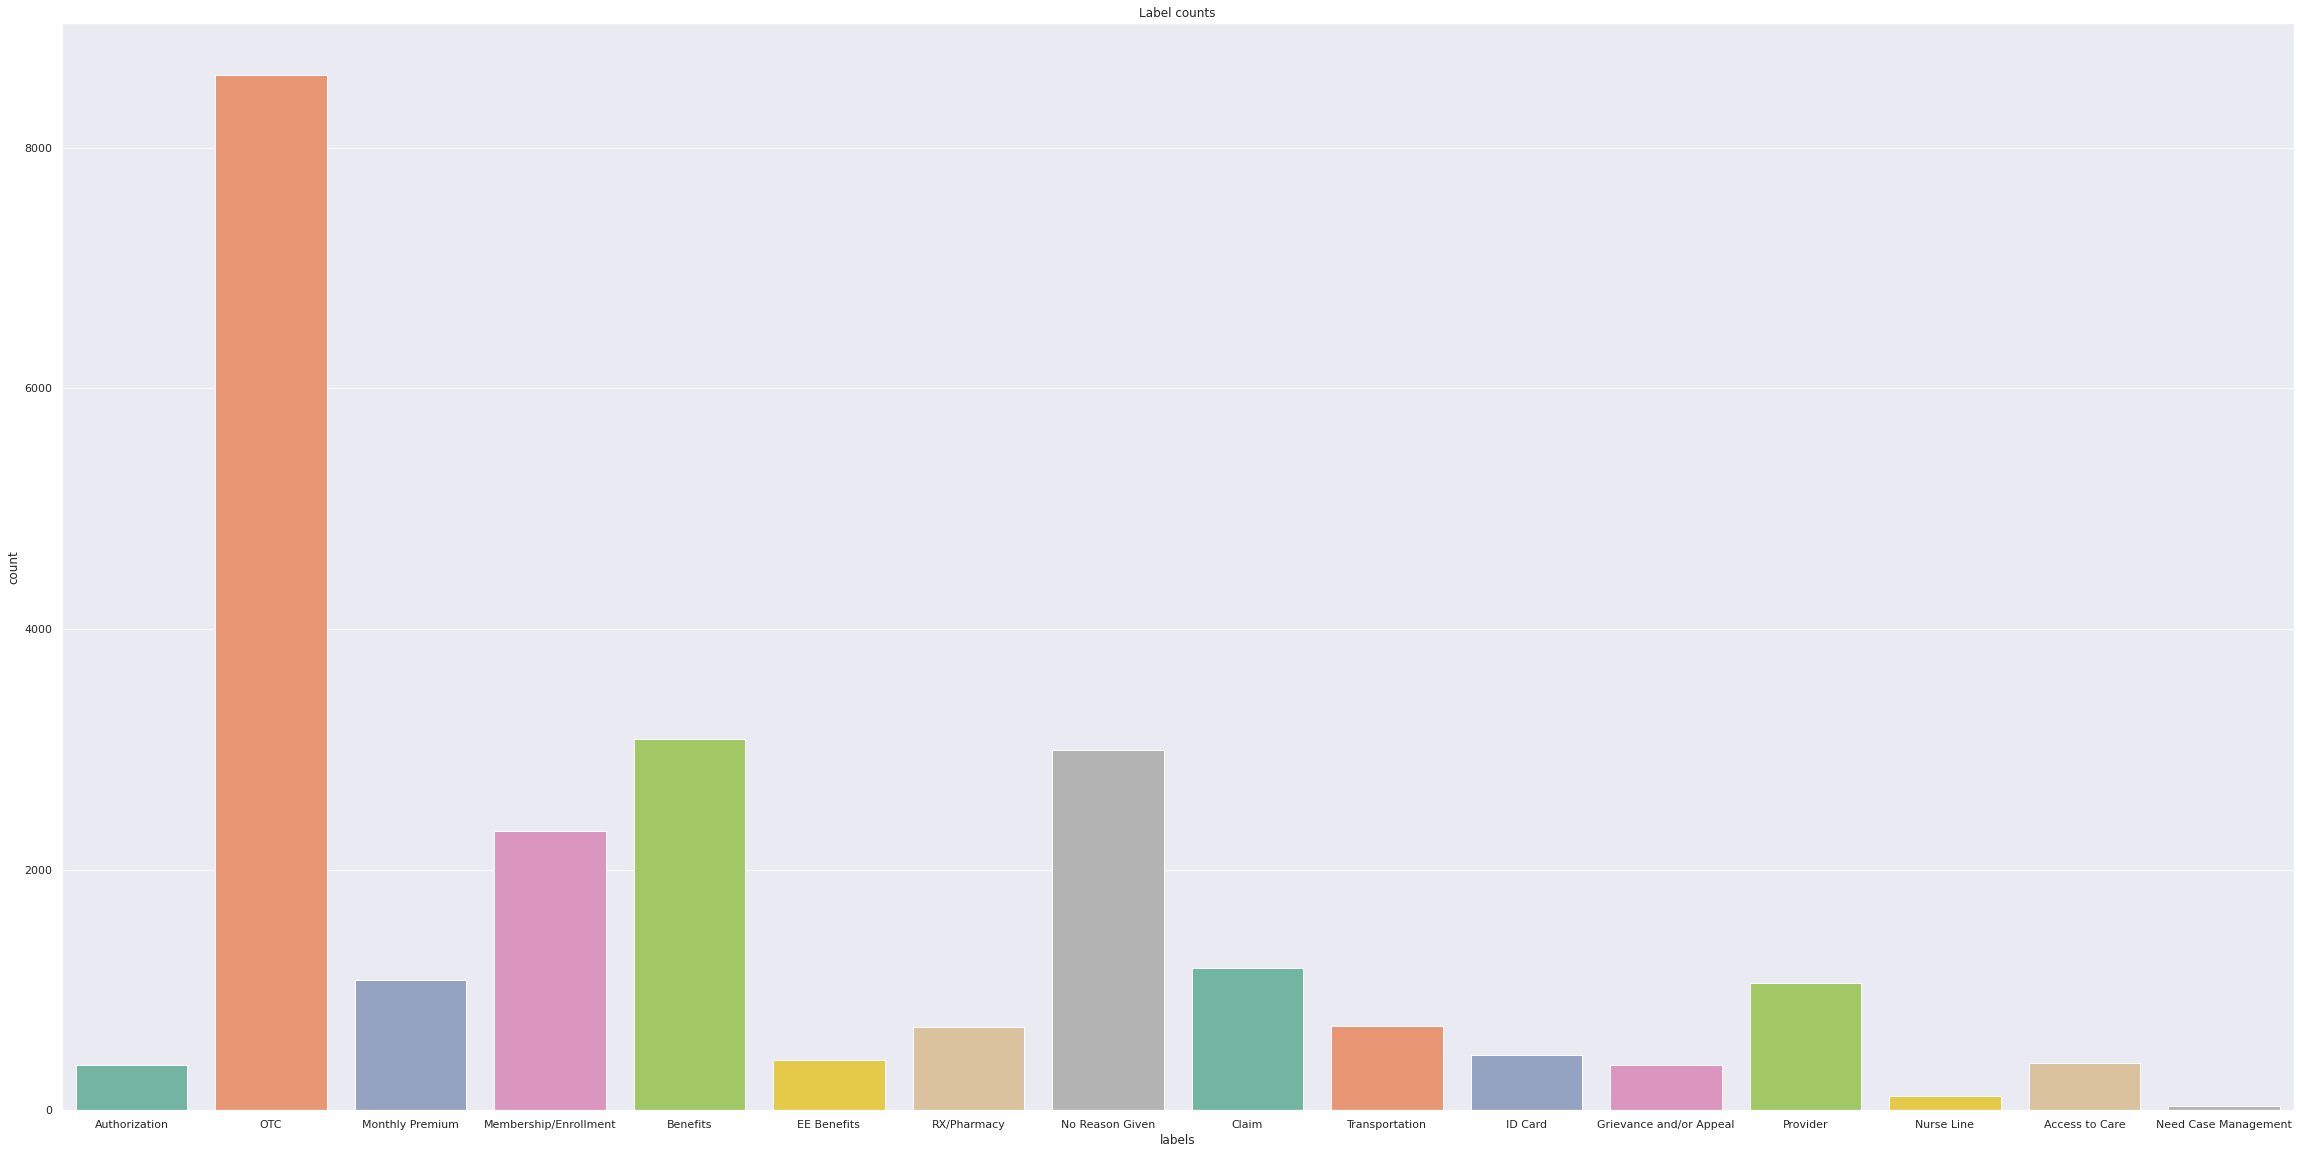

<IPython.core.display.Javascript object>

In [22]:
label_dataframe = pd.DataFrame(
    {"labels": cleaned_dataframe.loc[:, LABEL_COLUMN].apply(split_label).tolist()}
)
label_dataframe = pd.DataFrame(
    {"labels": [y for x in label_dataframe["labels"] for y in x]}
)

# Let's plot the counts of labelsin voice-mail data
plt.figure(figsize=(40, 20))  # setting the figure-size to width of 40 and height of 20
sns.set_theme(style="darkgrid")  # setting the theme to darkgrid
sns.countplot(x="labels", data=label_dataframe, palette="Set2").set_title(
    "Label counts"
)

#### **Conclusion:**
1. Above histogram shows counts of different labels i.e "Benefits", "Claim", "EE Benefits", "OTC", "Transportation" etc, training data has maximum number of OTC sentences !!

<br>
<font><h4> <b>We can look at word lengths of each sentence in Seaborn through a histplot</b></h4></font>

Text(0.5, 1.0, 'Word counts')

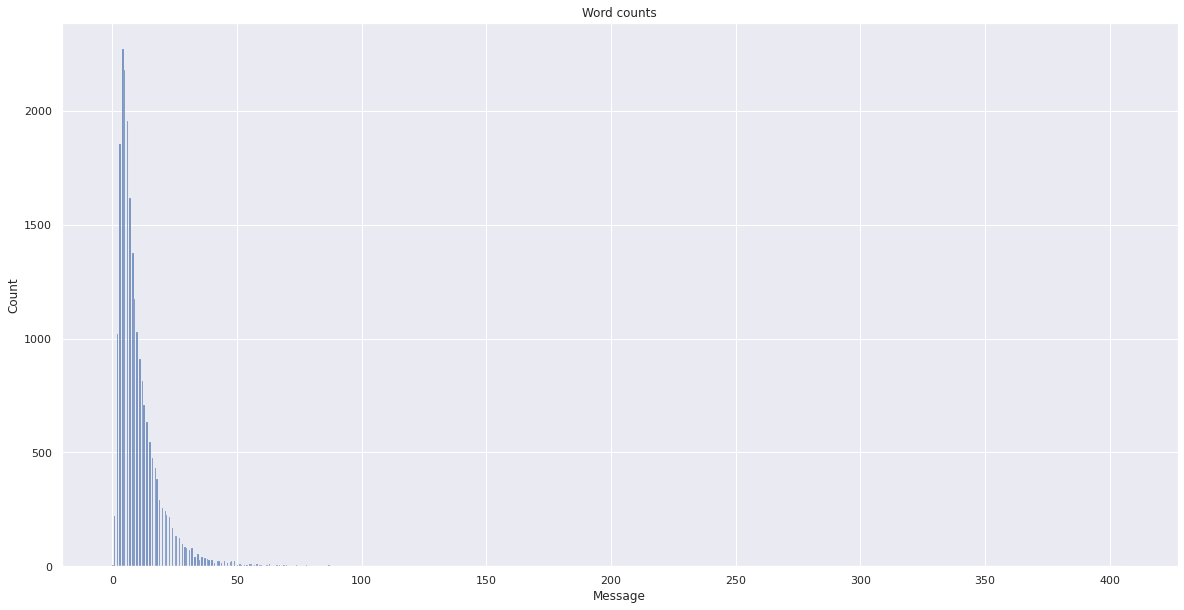

<IPython.core.display.Javascript object>

In [23]:
# Let's plot the word lengths of each sentence in voice-mail data
plt.figure(figsize=(20, 10))  # setting the figure-size to width of 20 and height of 10
sns.set_theme(style="darkgrid")  # setting the theme to darkgrid
sns.histplot(
    x=cleaned_dataframe.loc[:, MESSAGE_COLUMN].map(lambda x: len(x.split())),
    data=cleaned_dataframe,
).set_title("Word counts")

#### **Conclusion:**
1. Above histogram shows that sentences range from 5 to 160 words and generally, it is between 2 to 100 words.

<br>
<font color=magenta><h3> <b>Dataset Split</b></h3></font>

In [24]:
# Let's split the data into train and eval datsets with distribution of 0.75 and 0.25
processed_message = processed_dataframe.loc[:, MESSAGE_COLUMN].values
processed_label = process_label_data(label=processed_dataframe.loc[:, LABEL_COLUMN])
(
    train_sentences,
    eval_sentences,
    train_labels,
    eval_labels,
) = model_selection.train_test_split(
    processed_message,
    processed_label,
    test_size=0.20,
    random_state=42,
)
print("Shape of Input  Training Data    -->", train_sentences.shape)
print("Shape of Output Training Data    -->", train_labels.shape)
print("Shape of Input  Evaluation Data  -->", eval_sentences.shape)
print("Shape of Output Evaluation Data  -->", eval_labels.shape)

Shape of Input  Training Data    --> (5281,)
Shape of Output Training Data    --> (5281, 16)
Shape of Input  Evaluation Data  --> (1321,)
Shape of Output Evaluation Data  --> (1321, 16)


<IPython.core.display.Javascript object>

<br>
<font color=magenta><h3> <b>Feature Engineering</b></h3></font>

<font color=magenta><h4> <b>Word/Sentence Embeddings using BERT</b></h4></font>

In [25]:
# Let's initialize the Embeddings Class with model_name and model_type as parameters
model = RepresentationModel(
    model_type="bert", model_name="bert-base-uncased", use_cuda=True
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTextRepresentation: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTextRepresentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTextRepresentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>

In [26]:
# Let's convert the train and eval sentences into vectors/embeddings(BERT Embeddings)
train_sentence_vectors = model.encode_sentences(
    train_sentences, combine_strategy="mean"
)
eval_sentence_vectors = model.encode_sentences(eval_sentences, combine_strategy="mean")

<IPython.core.display.Javascript object>

<br>
<font color=magenta><h3> <b>Training & Evaluation</b></h3></font>

<font><h4> <b>Naive Bayes Classifier</b></h4></font>

In [27]:
naive_bayes_classifier = LabelPowerset(GaussianNB())
naive_bayes_classifier.fit(train_sentence_vectors, train_labels)

LabelPowerset(classifier=GaussianNB(), require_dense=[True, True])

<IPython.core.display.Javascript object>

In [28]:
train_accuracy, eval_accuracy = get_metrics(
    classifier=naive_bayes_classifier,
    train_sentence_vectors=train_sentence_vectors,
    eval_sentence_vectors=eval_sentence_vectors,
    train_labels=train_labels,
    eval_labels=eval_labels,
)

# Let's see the train and eval accuracy for information
print("Train Accuracy of Naive Bayes Classifier  -->", train_accuracy)
print("Eval  Accuracy of Naive Bayes Classifier  -->", eval_accuracy)

Train Accuracy of Naive Bayes Classifier  --> 0.44802120810452567
Eval  Accuracy of Naive Bayes Classifier  --> 0.3111279333838001


<IPython.core.display.Javascript object>

<font><h4> <b>Random Forest Classifier</b></h4></font>

In [29]:
random_forest_classifier = LabelPowerset(RandomForestClassifier())
random_forest_classifier.fit(train_sentence_vectors, train_labels)

LabelPowerset(classifier=RandomForestClassifier(), require_dense=[True, True])

<IPython.core.display.Javascript object>

In [30]:
train_accuracy, eval_accuracy = get_metrics(
    classifier=random_forest_classifier,
    train_sentence_vectors=train_sentence_vectors,
    eval_sentence_vectors=eval_sentence_vectors,
    train_labels=train_labels,
    eval_labels=eval_labels,
)

# Let's see the train and eval accuracy for information
print("Train Accuracy of Random Forest Classifier  -->", train_accuracy)
print("Eval  Accuracy of Random Forest Classifier  -->", eval_accuracy)

Train Accuracy of Random Forest Classifier  --> 1.0
Eval  Accuracy of Random Forest Classifier  --> 0.45571536714610145


<IPython.core.display.Javascript object>

<font><h4> <b>Support Vector Classifier</b></h4></font>

In [31]:
svm_classifier = LabelPowerset(SVC(probability=True))
svm_classifier.fit(train_sentence_vectors, train_labels)

LabelPowerset(classifier=SVC(probability=True), require_dense=[True, True])

<IPython.core.display.Javascript object>

In [32]:
train_accuracy, eval_accuracy = get_metrics(
    classifier=svm_classifier,
    train_sentence_vectors=train_sentence_vectors,
    eval_sentence_vectors=eval_sentence_vectors,
    train_labels=train_labels,
    eval_labels=eval_labels,
)
# Let's see the train and eval accuracy for information
print("Train Accuracy of SVM Classifier  -->", train_accuracy)
print("Eval  Accuracy of SVM Classifier  -->", eval_accuracy)

Train Accuracy of SVM Classifier  --> 0.638515432683204
Eval  Accuracy of SVM Classifier  --> 0.6018168054504164


<IPython.core.display.Javascript object>

<font><h4> <b>XGBoost Classifier</b></h4></font>

In [33]:
xgboost_classifier = LabelPowerset(XGBClassifier())
xgboost_classifier.fit(train_sentence_vectors, train_labels)

[14:34:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


LabelPowerset(classifier=XGBClassifier(base_score=0.5, booster='gbtree',
                                       colsample_bylevel=1, colsample_bynode=1,
                                       colsample_bytree=1,
                                       enable_categorical=False, gamma=0,
                                       gpu_id=-1, importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.300000012,
                                       max_delta_step=0, max_depth=6,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=100, n_jobs=32,
                                       num_parallel_tree=1,
                                       objective='multi:softprob',
                                       predictor='auto', random_state=0,
                                 

<IPython.core.display.Javascript object>

In [34]:
train_accuracy, eval_accuracy = get_metrics(
    classifier=xgboost_classifier,
    train_sentence_vectors=train_sentence_vectors,
    eval_sentence_vectors=eval_sentence_vectors,
    train_labels=train_labels,
    eval_labels=eval_labels,
)

# Let's see the train and eval accuracy for information
print("Train Accuracy of XGBoost Classifier  -->", train_accuracy)
print("Eval  Accuracy of XGBoost Classifier  -->", eval_accuracy)

Train Accuracy of XGBoost Classifier  --> 1.0
Eval  Accuracy of XGBoost Classifier  --> 0.43830431491294475


<IPython.core.display.Javascript object>

<font color=magenta><h3> <b>Hyper Parameter Tuning</b></h3></font>

<font><h4> <b>Support Vector Classifier</b></h4></font>

1. Observed that SVM is performing decently well with the below hyperparameters
    * C=2
    * kernel="poly"
    * gamma="scale"

In [35]:
# svc with poly kernel
svm_classifier = LabelPowerset(SVC(C=2, kernel="poly", gamma="scale", probability=True))
svm_classifier.fit(train_sentence_vectors, train_labels)

LabelPowerset(classifier=SVC(C=2, kernel='poly', probability=True),
              require_dense=[True, True])

<IPython.core.display.Javascript object>

In [36]:
train_accuracy, eval_accuracy = get_metrics(
    classifier=svm_classifier,
    train_sentence_vectors=train_sentence_vectors,
    eval_sentence_vectors=eval_sentence_vectors,
    train_labels=train_labels,
    eval_labels=eval_labels,
)
# Let's see the train and eval accuracy for information
print("Train Accuracy of SVM Classifier  -->", train_accuracy)
print("Eval  Accuracy of SVM Classifier  -->", eval_accuracy)

Train Accuracy of SVM Classifier  --> 0.7462601779965915
Eval  Accuracy of SVM Classifier  --> 0.6207418622255867


<IPython.core.display.Javascript object>

In [37]:
from skmultilearn.adapt import MLkNN

classifier = MLkNN(k=20)
classifier.fit(train_sentence_vectors, train_labels)

MLkNN(k=20)

<IPython.core.display.Javascript object>

<font><h5> <b>Model Saving(SVM)</b></h5></font>

In [38]:
# Let's save the svm model with best parameters onto S3 Bucket
save_model_into_s3(
    model_prefix=MODEL_PREFIX, model=svm_classifier, model_name=MODEL_NAME
)

<IPython.core.display.Javascript object>

<font><h4> <b>Random Forest Classifier</b></h4></font>

1. Random Forest is overfitting with default parameters i.e train accuracy is significantly higher than eval/test accuracy
1. Observed that Random Forest is performing decently well with the below hyperparameters
    * n_estimators= 4000
    * max_depth= 230

In [39]:
random_forest_classifier = LabelPowerset(
    RandomForestClassifier(n_estimators=3000, max_depth=450)
)
random_forest_classifier.fit(train_sentence_vectors, train_labels)

LabelPowerset(classifier=RandomForestClassifier(max_depth=450,
                                                n_estimators=3000),
              require_dense=[True, True])

<IPython.core.display.Javascript object>

In [40]:
train_accuracy, eval_accuracy = get_metrics(
    classifier=random_forest_classifier,
    train_sentence_vectors=train_sentence_vectors,
    eval_sentence_vectors=eval_sentence_vectors,
    train_labels=train_labels,
    eval_labels=eval_labels,
)

# Let's see the train and eval accuracy for information
print("Train Accuracy of Random Forest Classifier  -->", train_accuracy)
print("Eval  Accuracy of Random Forest Classifier  -->", eval_accuracy)

Train Accuracy of Random Forest Classifier  --> 1.0
Eval  Accuracy of Random Forest Classifier  --> 0.48750946252838756


<IPython.core.display.Javascript object>

In [41]:
random_forest_classifier = LabelPowerset(
    RandomForestClassifier(n_estimators=4000, max_depth=230)
)
random_forest_classifier.fit(train_sentence_vectors, train_labels)

LabelPowerset(classifier=RandomForestClassifier(max_depth=230,
                                                n_estimators=4000),
              require_dense=[True, True])

<IPython.core.display.Javascript object>

In [42]:
train_accuracy, eval_accuracy = get_metrics(
    classifier=random_forest_classifier,
    train_sentence_vectors=train_sentence_vectors,
    eval_sentence_vectors=eval_sentence_vectors,
    train_labels=train_labels,
    eval_labels=eval_labels,
)

# Let's see the train and eval accuracy for information
print("Train Accuracy of Random Forest Classifier  -->", train_accuracy)
print("Eval  Accuracy of Random Forest Classifier  -->", eval_accuracy)

Train Accuracy of Random Forest Classifier  --> 1.0
Eval  Accuracy of Random Forest Classifier  --> 0.48750946252838756


<IPython.core.display.Javascript object>

In [43]:
random_forest_classifier = LabelPowerset(
    RandomForestClassifier(n_estimators=5000, max_depth=450)
)
random_forest_classifier.fit(train_sentence_vectors, train_labels)

LabelPowerset(classifier=RandomForestClassifier(max_depth=450,
                                                n_estimators=5000),
              require_dense=[True, True])

<IPython.core.display.Javascript object>

In [44]:
train_accuracy, eval_accuracy = get_metrics(
    classifier=random_forest_classifier,
    train_sentence_vectors=train_sentence_vectors,
    eval_sentence_vectors=eval_sentence_vectors,
    train_labels=train_labels,
    eval_labels=eval_labels,
)

# Let's see the train and eval accuracy for information
print("Train Accuracy of Random Forest Classifier  -->", train_accuracy)
print("Eval  Accuracy of Random Forest Classifier  -->", eval_accuracy)

Train Accuracy of Random Forest Classifier  --> 1.0
Eval  Accuracy of Random Forest Classifier  --> 0.49356548069644207


<IPython.core.display.Javascript object>

<font color=magenta><h3> <b>Metrics</b></h3></font>

In [45]:
# Let's get the classification report of finetuned SVC
y_pred = svm_classifier.predict(eval_sentence_vectors)
classification_report = metrics.classification_report(
    y_true=eval_labels, y_pred=y_pred, target_names=LABELS, output_dict=True
)

<IPython.core.display.Javascript object>

In [46]:
# Let's create a dataframe of classification report and see what's in it
classification_report_df = pd.DataFrame(classification_report).transpose()
classification_report_df

,precision,recall,f1-score,support
Access to Care,0.181818,0.048193,0.076190,83.0
Authorization,0.500000,0.195122,0.280702,41.0
Benefits,0.714286,0.367232,0.485075,177.0
Claim,0.751592,0.706587,0.728395,167.0
EE Benefits,0.800000,0.137931,0.235294,29.0
Grievance and/or Appeal,0.884615,0.333333,0.484211,69.0
ID Card,0.740741,0.769231,0.754717,78.0
Membership/Enrollment,0.698113,0.751269,0.723716,197.0
Monthly Premium,0.875000,0.538462,0.666667,52.0
Need Case Management,0.000000,0.000000,0.000000,4.0


<IPython.core.display.Javascript object>

<AxesSubplot:>

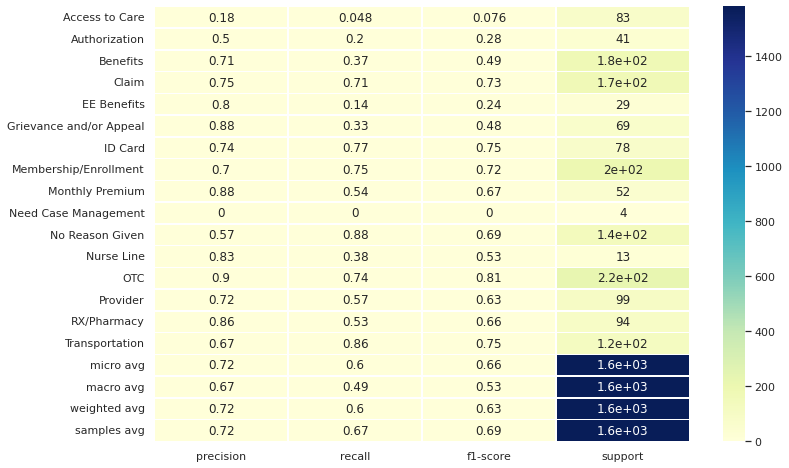

<IPython.core.display.Javascript object>

In [47]:
# Let's plot the heatmap of classification report
plt.figure(figsize=(12, 8))  # setting the figure-size to width of 12 and height of 8
sns.set_theme(style="darkgrid")  # setting the theme to darkgrid
sns.heatmap(data=classification_report_df, annot=True, linewidths=0.5, cmap="YlGnBu")